# SPIRiT: Iterative Self-consistent Parallel Imaging Reconstruction From Arbitrary k-Space 
Michael Lustig and John M. Pauly, 2010

## Background

### Categories of previous algorithms
__SPIRiT__ is an autocalibrating, coil-by-coil method. 

Autocalibrating methods such as __GRAPPA__, PILS, auto-SMASH, APPEAR indirectly rely on sensitivity maps whereas coil sensitivity map methods such as __SENSE__, SPACE-RIP, PARS, kSPA directly rely on sensitivity maps. These maps are difficult to accurately measure or estimate very accurately and these errors are often amplified in reconstruction. 

Coil image targets such as __GRAPPA__, PILS, PARS reconstruct each coil image and then arbitrarily combines them whereas single image target methods such as __SENSE__, auto-SMASH, SPACE_RIP reconstruct a single combined image.

### Inspiration from SENSE and GRAPPA
SPIRiT draws its inspiration from SENSE and GRAPPA. SENSE is the optimal and most general solution if sensitivity profiles are known but this is not often the case. However, GRAPPA doesn't require these sensitivity profiles but it doesn't generalise to non-cartesian coordinates like SENSE. Therefore, SPIRiT is based on GRAPPA's reconstruction, but with improved generalisability from a SENSE-like inverse problem formulation.

### GRAPPA Revision
Translation variant interpolation problem in k-space formulated as linear combination of acquired neighbours

$$x_i(r) = \sum_j g_{rji}^*(\hat{R}_rx_i) \tag{1}$$

Where:
* $r$ is an arbitrary position 
* $x_i(r)$ is the k-space value of the $i^{th}$ coil at position $r$
* $R_r$ operates on $x_i$ to choose neighbours of $r$ in the k-space of the $i^{th}$ coil 
    * $\hat{R}_r$ selects the subset of $R_r$ comprising purely of acquired points 
    * Can have different sampling patterns for different points/areas (i.e. $R_r$) 
* $g_{rji}$ is a vector of weights from calibration for an arbitrary sampling of $j$ neighbours of $r$ 
    * $g_{rji}^*$ is its transpose-conjugate
    
The vector $g_{ri}$ is calibrated with fully-acquired k-space data. Some subset, $\rho$ of the calibration data is used to interpolate the calibration data, and the least-squares error is minimised. This is formulated as:

$$g_{ri} = \arg\min_{g_{ri}} \sum_{\rho}\Big|\Big| \sum_j g_{rji}^*(\hat{R}_{\rho}x_j) - x_i(\rho)\Big|\Big|^2 \tag{2}$$

This can be reformulated into matrix form:

$$g_{ri} = \arg\min_{g_{ri}}||\hat{X}^*g_{ri}-x_i||^2 \tag{3}$$

Where:
   * $\hat{X}^*$ are the $\hat{R}_r x_i$ that are in the callibration area of the k-space 

This has the closed-form, least-squares solution (with Tikhonov regularisation):

$$g_{ri} = (\hat{X}^*\hat{X} + \beta I)^{-1}\hat{X}^*x_i \tag{4}$$

## Methodology

### SPIRiT formulation
SPIRiT is formulated as an inverse problem with "Consistency constraints". The desired reconstruction, $x$, from an arbitrary k-space pattern, is a complete Cartesian  k-space for all coils. 

#### Consistency with the Calibration
SPIRiT's consistency with the calibration is an expanded notion of consistency from GRAPPA. While GRAPPA ensures consistency between synthesized point and nearby acquired points, SPIRiT ensures consistency between all points, synthesized or acquired, across all points in neighbourhood of $r$. SPIRiT also ensures consistency across coils.

This gives a slightly different formulation to GRAPPA:

$$x_i(r) = \sum_j g_{ji}^*(R_r x_j) \tag{5}$$

There are three differences to GRAPPA in this formulation:
* $R_r$ instead of $\hat{R}_r$: consistency is enforced on synthesised and acquired points
* $g_{ji}$ instead of $g_{rji}$: kernel is the same for all positions, and operates on all points in neighbourhood
* $x_j$ instead of $x_i$: neighbourhood region across all coils 
* Coupled instead of decoupled linear equations 

Since consistency is ensured across all points, this can be reformulated as a convolution ($\otimes$):

$$x_i = \sum_j g_{ji} \otimes x_j \tag{6}$$

Aggregating the $g_{ji}$'s into a matrix $G$, gives the simpler representation:

$$x=Gx \tag{7}$$

This is intuitive considering that correct calibration consistency should synthesise all points in any subset of 
$x$ to $x$. 

<img src="pics/sampling_patterns.jpg">

#### Consistency with the Data Acquisition 
SPIRiT's consistency with the data acquisition ensures consistency with the non-necessarily cartesian, acquired data $y$.

$$y=Dx \tag{8}$$

* $y$ is the concatenated data from all coils
* $D$ is a linear operator mapping the cartesian coordinates of the final reconstructed solution to the acquired data

#### Combined Optimisation Formulation 
These two consistency considerations can be formulated into:

$$x = \arg\min_x ||(G-I)x||^2 \tag{9}$$ subject to $$||Dx-y||^2 \le \epsilon $$

Where 
* $\epsilon$ is a threshold to trade-off calibration and data acquisition consistency. 

This is advantageous as the minimisation is on the calibration consistency which is always in cartesian coordinates even if $y$ is not. Alternatively, this can be formulated in an unconstrained Lagrangian form:

$$x = \arg\min_x||Dx-y||^2 + \lambda(\epsilon)||(G-I)x||^2 \tag{10}$$

This is solved iteratively through descent methods, all of which rely on rapid computation of the objective function: 

$$\nabla_x\{||Dx-y||^2 + \lambda(\epsilon)||(G-I)x||^2\} = 2D^*(Dx-y)+\lambda2(G-I)^*(G-I)x \tag{11}$$

For example, a steepest descent algorithm with step size $\mu$ would iterate as:

$$x_{n+1} = x_n - \mu[D^*(D-y)+\lambda(G-I)^*(G-I)x] \tag{12}$$

#### Arbitrary Cartesian Sampling
In the specific case where the sampling is also cartesian, then it is common to enforce the data acquisition equality constraint ($\epsilon \rightarrow 0$)

$$x = \arg\min_x||Dx-y||^2 + \lambda||(G-I)x||^2 \tag{13}$$
    
A useful reformulation is:

$$x = D^Ty + D_c^T \hat{x} \tag{14}$$

Where: 
* $\hat{x}$ are all non-acquired points
* $D$ is a linear map, but now only for acquired points
    * $D^T$ is its inverse
* $D_c$ is a similar linear map, but only for nonacquired points ($\hat{x}$)
* $D_c^T$ is its inverse

Substituting this into the above Lagragian formulation gives:

$$x = \arg\min_x||D(D^Ty + D_c^T)-y||^2 + \lambda||(G-I)(D^Ty + D_c^T \hat{x})||^2$$
$$x = \arg\min_x||y+0-y||^2 + \lambda||(G-I)D^Ty + (G-I)D_c^T\hat{x}||^2$$
$$x = \arg\min_x||(G-I)D_c^T\hat{x} + (G-I)D^Ty||^2 \tag{15}$$

From inspection, this is a least squares problem, where:

$A = (G-I)D_c^T \tag{16}$
$b = (G-I)D^Ty \tag{17}$ 

### Calibration 
The calibration for ESPIRiT consists of the interpolation of k-space subspace and the computation of full kernel weights akin to GRAPPA. This assumes sufficient sampling of a subspace of k-space (e.g. around the center of a radially sampled k-space) 

In [1]:
using Images 

### k-Space Domain Reconstruction

The problem to solve is 

$$
\text{argmin}_x || Dx - y ||^2 + \lambda(\epsilon)||(G-I)x||^2.
$$

To approximate the data consistency constraint

$$
y = Dx
$$

we use a convolution interpolation to interpolate from Cartesian onto the non-Cartesian k-space grid and vice versa.

Suppose we interpolate from a Cartesaion grid to a non-Cartesian grid. Let $c$ be an interpolation kernel, $k$ be the non-Cartesian k-space coordinates, and $\delta(x)$ be the dirac-delta function. We write the operation 
$D$ applied to the ith coil’s data as,

$$ y_i(n) = \int_r \delta(k(n) - r)\{c \ast x_i\}(r)\; dr$$

Using a sinc function as interpolation kernel would be ideal, however, it has a prohibitively large kernel size. The solution obtained by a nonsinc kernel cannot be exactly $x_i$, but a function of it. Let $\tilde{c}$ be a convolution kernel such that $c\ast\tilde{c} = \delta$, then

$$
\tilde{x}_i = \tilde{c}\ast x_i
$$

so, $c\ast \tilde{x}_i = c\ast\tilde{c}\ast x_i ≈ x_i.$

In image domain we have

$$
\tilde{m}_i(r) = \tilde{C}(r)m_i(r) = \frac{1}{C(r)} m_i(r)
$$

where $m_i,\tilde{m}_i, \tilde{C}, C$ denote the inverse Fourier transform of of $x_i, \tilde{x}_i, \tilde{c} , c$, respectively.

the solution $\tilde{x}$ may no longer be consistent with the data calibration constraint $x=Gx$.
To mitigate the problem one should design a kernel with ripple constraints on the passband, as well as the stop band e.g. windowed-sinc kernel.

The steps for non-Cartesian k-space-based reconstruction are as follows: 
- Design an appropriate interpolation kernel based on a specific maximum aliasing amplitude, image weighting, kernel width, and grid oversampling
- Perform a calibration that supports the oversampled grid size to obtain the calibration weights
- Solve the optimization problem using the CG algorithm to obtain reconstructed Cartesian k-space data for all coils
- Reconstruct the images by computing the inverse Fourier transform
- Crop to the desired grid size 
- Apodize the images by multiplying with the inverse Fourier transform of the interpolation kerne

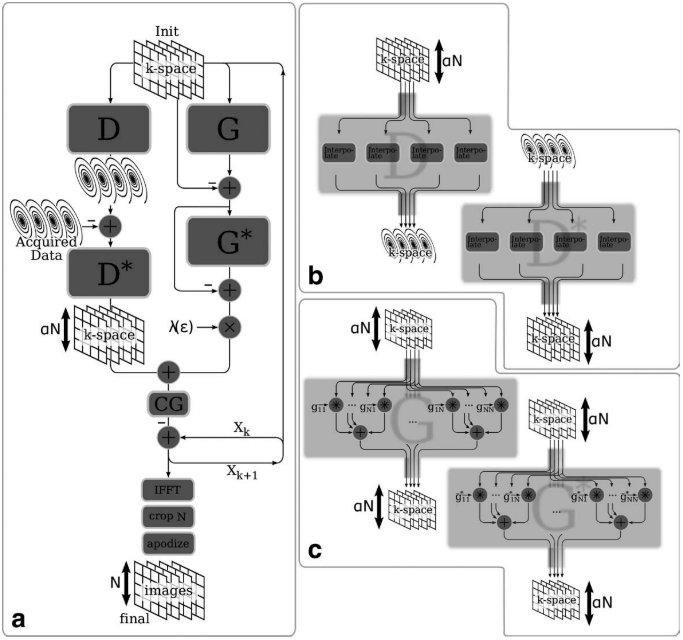

In [3]:
img = load("kspace_recon.png")

### Image Domain Reconstruction

The reconstruction is performed by adjusting the the operators $D$ and $G$ appropriately and then solve for the full Cartesian images $m$. The optimization problem takes the form


$$
\text{argmin}_m || Dm - y ||^2 + \lambda(\epsilon)||(G-I)m||^2
$$

with coil images $m_i = \text{IFFT}_N(x)$ where $N$ is the grid size.

Operator $D$ becomes a series of non-uniform Fourier transformations that operates on the individual coil images. It is defined by 

$$ y_i(n) = \int_r \delta(k(n) - r)\{c \ast \text{FFT}_{\alpha N} \bigg(\frac{m_i}{C}\bigg)\}(r)\; dr$$

where $\alpha$ is the grid oversampling factor. The operator $G$ becomes a multiplication with the inverse Fourier transform of the convolution kernels,

$$
m_i(r) = \sum_j G_{ji}(r)m_j(r)
$$

where $G_{ji} = \text{IFFT}_N(g_{ji})$

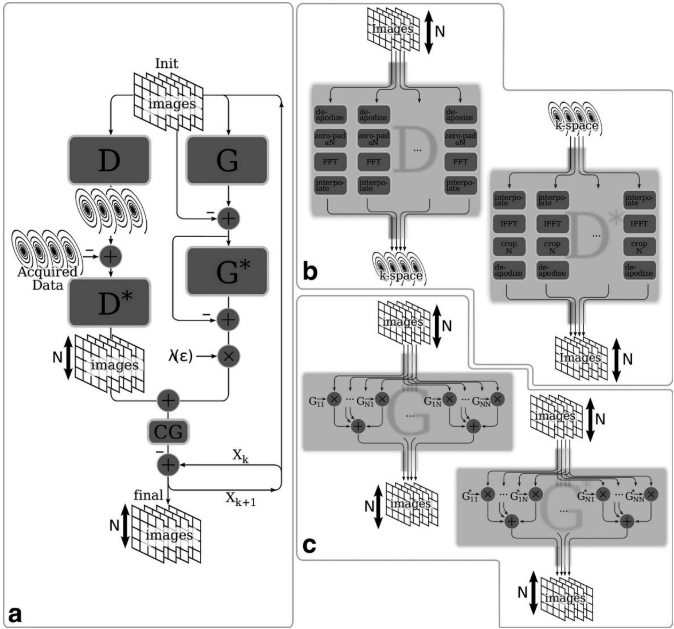

In [7]:
img = load("imspace_recon.png")

### Results

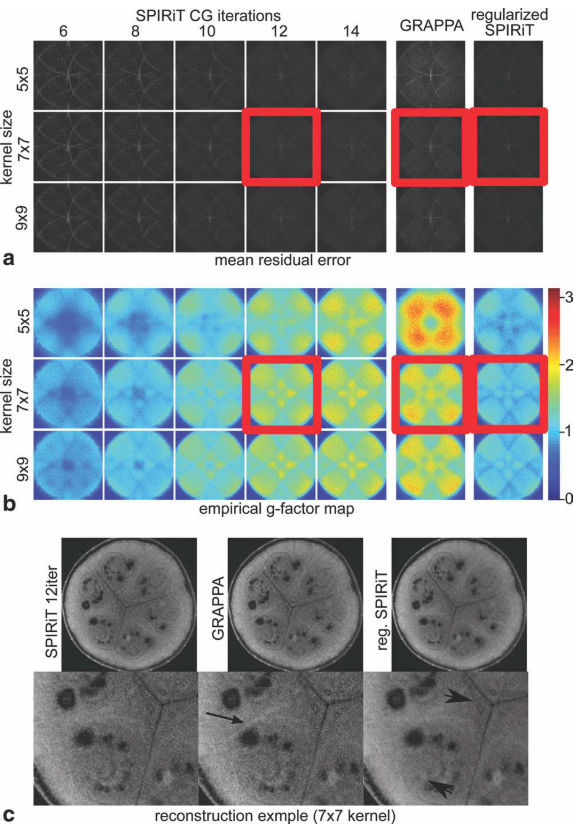

In [9]:
img = load("res1.png")

Empirical reconstruction error and noise amplification maps of SPIRiT, GRAPPA, and $\ell_1$-wavelet regularized SPIRiT obtained from 100, scans, using eight channels and 4-fold acceleration. a: The mean residual of SPIRiT as a function of kernel size and number of CG iterations show convergence around 10-12 iterations and overall insensitivity to kernel size. GRAPPA exhibits larger residuals than SPIRiT, especially for smaller kernel sizes. The $\ell_1$-wavelet regularization does not reduce the accuracy of the reconstruction (e.g., does not introduce image blurring). b: The empirical g-factor maps demonstrate the inherent regularization and noise reduction in early termination of CG. SPIRiT exhibits an overall lower noise amplification than GRAPPA for similar residual error. The $\ell_1$-wavelet regularization exhibits almost no noise amplification at all. c: Reconstruction example. The black arrow points to residual aliasing in GRAPPA that is absent in SPIRiT. The arrowheads point to significant noise reduction in the $\ell_1$-wavelet regularized SPIRiT.

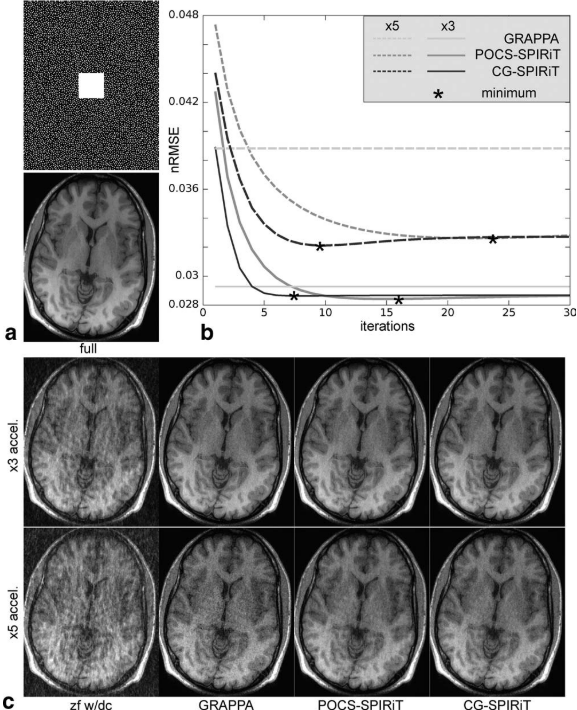

In [12]:
img = load("res2.png")

CG-SPIRiT and POCSSPIRiT from 3-fold and 5-fold arbitrary Cartesian sampling using eight channels. a: five-fold acceleration Poisson-Disc density sampling pattern and the reconstruction from the full data. b: Normalized RMSE (nRMSE) as a function of iterations. The advantage of SPIRiT shows at higher acceleration where efficient use of the acquired data becomes crucial. c: Examples of the various reconstruction. Note the reduction in noise and artifacts in the SPIRiT reconstructions from 5-fold accelerated data.

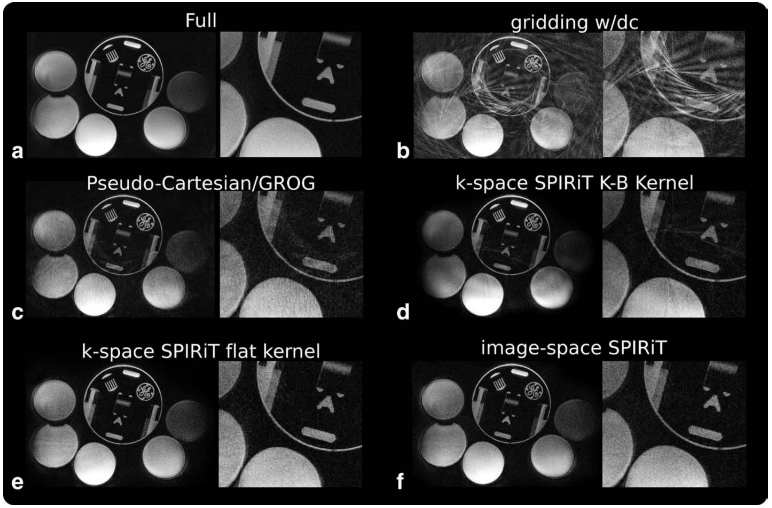

In [15]:
img = load("res3.png")

Non-Cartesian SPIRiT reconstruction from 3-fold undersampled spirals and four channels. a: Reconstruction from fully sampled data. b: Gridding with density compensation. c: Pseudo-Cartesian GRAPPA with GROG. d: k-Space SPIRiT with Kaiser-Bessel interpolator kernel. e: k-Space SPIRiT with flat passband interpolator kernel. f: Image-space SPIRiT.

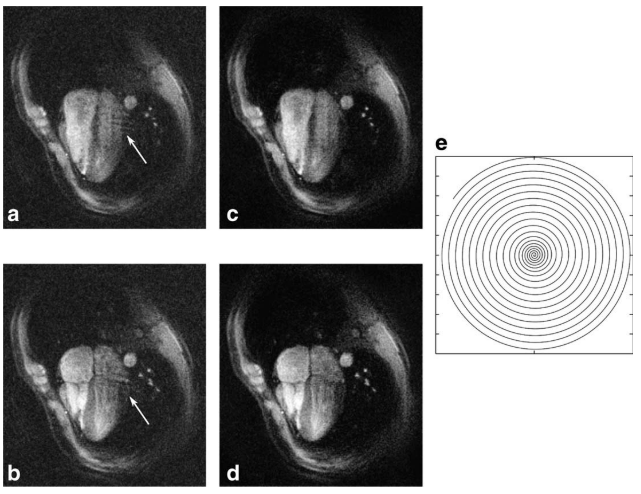

In [14]:
img = load("res5.png")

Dynamic cardiac imaging with dual-density spirals with 3-fold acceleration and four channels. Two phases of a four-chamber view of the heart. a,b: Sum of squares of gridding reconstruction exhibits coherent (arrows) and incoherent (noiselike) aliasing artifacts. c,d: Both the coherent and incoherent artifacts are removed by SPIRiT. e: One out of the three spiral interleaves.

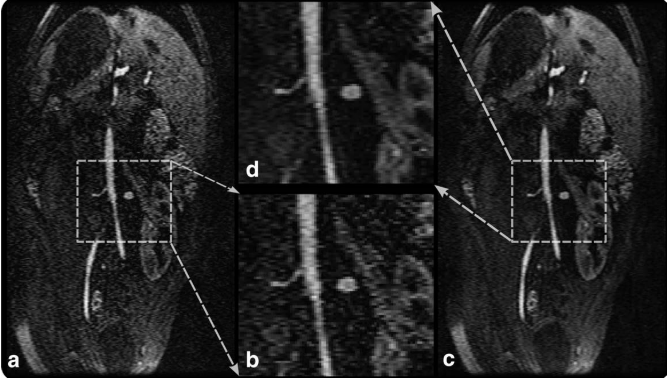

In [17]:
 img = load("res6.png")

$\ell_1$-wavelet regularization of 4-fold accelerated postcontrast abdomen scan with a 12-channel body coil. a: the nonregularized GRAPPA reconstruction exhibits noise amplification due to the g factor, especially in the middle of the image. b: Zoomed-in GRAPPA reconstruction. c: The noise amplification is suppressed in the $\ell_1$-wavelet regularized SPIRiT reconstruction, while the edges and features in the image are preserved. d: Zoomed-in $\ell_1$-wavelet regularized SPIRiT reconstruction.

### Conclusive Remarks

- better noise performace than GRAPPA because the acquired data is used more efficiently

- due to iterative process, the computational complexity of can be more intensive than direct reconstruction

- CG Cartesian algorithm requires two GRAPPA-type operations per iteration

- able to reconstuct from highly nonuniform sampling patterns

- imagine-domain approach is preferred beacuse it is more effcient and natural, e.g. parameter choices, regularization 